In [1]:
!pip install youtokentome
!pip install datasets

     |████████████████████████████████| 1.7 MB 4.3 MB/s 
     |████████████████████████████████| 306 kB 4.2 MB/s 
     |████████████████████████████████| 132 kB 50.4 MB/s 
     |████████████████████████████████| 243 kB 31.2 MB/s 
     |████████████████████████████████| 1.1 MB 38.2 MB/s 
     |████████████████████████████████| 61 kB 249 kB/s 
     |████████████████████████████████| 271 kB 36.0 MB/s 
     |████████████████████████████████| 160 kB 31.8 MB/s 
     |████████████████████████████████| 192 kB 42.5 MB/s 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import gzip
import math
import youtokentome as yttm

from datasets import load_dataset
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

In [3]:
# Для загрузки данных и моделей с гугл-драйва
# from google.colab import drive
# drive.mount('/content/drive')
# %cd ../content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


## Словарь и датасет

In [4]:
data = pd.read_csv('train.txt', sep='\t', header=None, names=['Q', 'A'])

In [ ]:
data.head()

,Q,A
0,"он трогает меня там и я не могу сказать нет, п...",хочется тебе этого. поэтому и молчишь. молчани...
1,а приличная поза.это какая? ),все приличные. лишь бы поглубже забратся!)
2,с какой фразы начинается ваше доброе утро.) до...,в даный момент рота подъем.)
3,нужен ли автомобиль семье с маленьким ребенком?,еще как нужен !
4,как вам мое фото?,наверное подслушивать очень любишь.)


In [ ]:
# собираем файл для обучения BPE (файл уже готов и лежит в папке проекта)
# with open('for_bpe.txt', 'w', encoding='utf-8') as f:
#     for que in data.Q:
#         f.write(que + '\n')
#     for ans in data.A:
#         f.write(ans + '\n')

In [5]:
# параметры
vocab_size = 32_000
model_path = 'pretrained_bpe_lm.model'

# обучаем (обученная модель уже лежит в папке проекта)
# yttm.BPE.train(data='for_bpe.txt', vocab_size=vocab_size, model=model_path)

In [7]:
# загружаем токенизатор
tokenizer = yttm.BPE(model=model_path)
tokenizer.vocab()[31000:31015]

['ata',
 'вом.',
 'мочки',
 '▁обажа',
 '▁подце',
 '▁раск',
 '▁ed',
 'рования',
 'emy',
 'любли',
 'част',
 '▁эксперимен',
 '▁должность',
 'вы!',
 '▁уравнове']

In [8]:
# токенизируем половину датасета (весь занимает слишком много памяти)

batch_size = 256

token_q = []
token_a = []

for i_batch in tqdm(range(math.ceil(len(data.Q) / (2*batch_size)))):
    
    token_q.extend(tokenizer.encode(list(data.Q[i_batch*batch_size:(i_batch+1)*batch_size]), bos=False, eos=False))
    token_a.extend(tokenizer.encode(list(data.A[i_batch*batch_size:(i_batch+1)*batch_size]), bos=True, eos=True))

  0%|          | 0/11486 [00:00<?, ?it/s]

In [9]:
# проверяем длины вопросов и ответов

lengths_q = np.array([len(x) for x in token_q])
lengths_a = np.array([len(x) for x in token_a])
n_q = int(np.percentile(lengths_q, q=98))
n_a = int(np.percentile(lengths_a, q=95))

print('98%% percent of questions are of length %i ; 95%% of answers are of length %i' % (n_q,n_a))

98% percent of questions are of length 16 ; 95% of answers are of length 16


In [10]:
max_len = 16
min_len = 4

pad_index = 0

In [11]:
len(token_q)

2940416

In [12]:
# отфильтровываем вопросы и ответы со слишком большой и слишком маленькой длиной

exclude_idxs = []
for i in tqdm(range(len(token_q))):
    if  len(token_q[i])>max_len or len(token_a[i])>max_len or len(token_q[i])<min_len or len(token_a[i])<min_len:
        exclude_idxs.append(i)

filtered_q = np.array(token_q)[~np.in1d(range(len(token_q)), exclude_idxs)]
filtered_a = np.array(token_a)[~np.in1d(range(len(token_a)), exclude_idxs)]

  0%|          | 0/2940416 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


In [13]:
filtered_q.size

2712326

In [14]:
del token_q
del token_a

In [15]:
# класс для датасета

class QAData(torch.utils.data.Dataset):
    
    def __init__(self, questions, answers, max_len, pad_index):
        
        self.q = questions
        self.a = answers
        
        self.max_len = max_len
        
        self.pad_index = pad_index
        
    def __len__(self):
        return len(self.q)
    
    def __getitem__(self, index):
        
        # входящая последовательность вопроса
        x = self.q[index]
        
        pads_q = [self.pad_index] * (self.max_len - len(x))
        
        # входящая последовательность ответа
        y = self.a[index][:-1]
        # нужно предсказать смещенную последовательность
        z = self.a[index][1:]
        
        assert len(z) == len(y)
        
        pads_a = [self.pad_index] * (self.max_len - len(z))
        
        # паддинг ставим в начало вопроса, чтобы смысловая составляющая сохранилась при передаче памяти декодеру
        x = torch.tensor(pads_q + x).long()
        y = torch.tensor(y + pads_a).long()
        z = torch.tensor(z + pads_a).long()
        
        return x, y, z

In [16]:
indices = np.arange(filtered_q.size)
train_inds, val_inds = train_test_split(indices, test_size=0.1) # разделяем данные на train и validation

train_dataset = QAData(filtered_q[train_inds], filtered_a[train_inds], max_len, pad_index)
val_dataset = QAData(filtered_q[val_inds], filtered_a[val_inds], max_len, pad_index)

len(train_dataset), len(val_dataset)

(2441093, 271233)

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [18]:
for x, y, z in train_loader:
    break

In [19]:
x, y, z

(tensor([[    0,     0,     0,  ..., 14037,  5593, 11691],
         [    0,     0,     0,  ..., 13144, 16539, 14011],
         [    0,     0,     0,  ...,  2739,  1440,  3961],
         ...,
         [    0,     0,  1658,  ...,  1327,  1352, 19905],
         [    0,     0,  1295,  ...,  1569,    14, 27102],
         [    0,     0,     0,  ...,  2765,  2078,  3343]]),
 tensor([[   2, 2323, 1295,  ..., 3740,   29,    0],
         [   2, 2240, 4913,  ...,    0,    0,    0],
         [   2, 1416, 1280,  ...,    0,    0,    0],
         ...,
         [   2, 1289, 4408,  ...,    0,    0,    0],
         [   2, 1866, 1412,  ...,    0,    0,    0],
         [   2, 1472, 1413,  ...,    0,    0,    0]]),
 tensor([[ 2323,  1295,  2707,  ...,    29,     3,     0],
         [ 2240,  4913,  1296,  ...,     0,     0,     0],
         [ 1416,  1280,  8051,  ...,     0,     0,     0],
         ...,
         [ 1289,  4408,    27,  ...,     0,     0,     0],
         [ 1866,  1412, 10689,  ...,     0,   

In [20]:
print([tokenizer.vocab()[i] for i in x[0].tolist()])

['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '▁подскажите', '▁марку', '▁вкусного', '▁кака', 'о?']


In [21]:
print([tokenizer.vocab()[i] for i in z[0].tolist()])

['▁то,', '▁что', '▁прода', 'валось', '▁в', '▁совет', 'ское', '▁время.', '▁сейчас', '▁-', '▁подде', 'лки', '▁одни', '.', '<EOS>', '<PAD>']


In [ ]:
z.shape

torch.Size([64, 16])

## Модель

In [22]:
class Seq2seq_Model(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, model_dim, num_layers, dropout, padding_idx, weight_tying=True):
        
        super().__init__()
        
        self.emb_dim = embedding_dim
        self.model_dim = model_dim
        
        # входные эмбеддинги
        self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size, 
                                                  embedding_dim=self.emb_dim,
                                                  padding_idx=padding_idx)
        
        # lstm для энкодера
        self.lstm_enc = torch.nn.LSTM(input_size=self.emb_dim, 
                                    hidden_size=model_dim,
                                    num_layers=num_layers,
                                    batch_first=True)
        
        # lstm для декодера
        self.lstm_dec = torch.nn.LSTM(input_size=self.emb_dim, 
                                    hidden_size=model_dim,
                                    num_layers=num_layers, 
                                    dropout=dropout,
                                    batch_first=True)
        
        # attention layer
        self.values = nn.Linear(self.model_dim, self.emb_dim, bias=False)
        self.keys = nn.Linear(self.model_dim, self.emb_dim, bias=False)
        self.queries = nn.Linear(self.model_dim, self.emb_dim, bias=False)
        
        
        
        # выходная матрица эмбеддингов
        self.language_model_head = torch.nn.Linear(in_features=model_dim,
                                                   out_features=vocab_size,
                                                   bias=False)
        
        # шарим веса для входных и выходных эмбеддингов
        if weight_tying and embedding_dim == model_dim:
            self.language_model_head.weight = self.embedding_layer.weight
        
    def forward(self, x, y):
        
        # пропускаем вопрос через энкодер
        x = self.embedding_layer(x)
        
        x, s = self.lstm_enc(x)
        
        # пропускаем ответ и финальные hidden state и cell state через декодер
        y = self.embedding_layer(y)
        
        y, _ = self.lstm_dec(y, s)
        
        # считаем values, keys и queries
        values = self.values(x)
        keys = self.keys(x)
        queries = self.queries(y)
        
        # перемножаем keys и queries
        energy = torch.einsum("nqd, nkd->nqk", [queries, keys])
        
        # пропускаем через softmax
        attention = torch.softmax(energy / (self.emb_dim ** (1/2)), dim=2)
        
        # взвешиваем values
        values = torch.einsum('nql, nld->nqd', [attention, values])
        
        # усредняем вектор декодера с выходом attention и переводим в предсказание
        pred = self.language_model_head((y+values)/2)
        
        return pred

In [23]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

embedding_dim = 256
model_dim = 256
num_layers = 2
dropout = 0.3

model = Seq2seq_Model(vocab_size, embedding_dim, model_dim, num_layers, dropout, pad_index, weight_tying=True)
model.to(device)

Seq2seq_Model(
  (embedding_layer): Embedding(32000, 256, padding_idx=0)
  (lstm_enc): LSTM(256, 256, num_layers=2, batch_first=True)
  (lstm_dec): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.3)
  (values): Linear(in_features=256, out_features=256, bias=False)
  (keys): Linear(in_features=256, out_features=256, bias=False)
  (queries): Linear(in_features=256, out_features=256, bias=False)
  (language_model_head): Linear(in_features=256, out_features=32000, bias=False)
)

## Обучение

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=pad_index, reduction='none')
scheduler = None
clip = 3.

In [25]:
# Вспомогательные функции

# Функция для выведения графиков
def plot_losses(train_losses, test_losses):
    
    clear_output()
    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    
    axs.plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs.plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs.set_ylabel('loss')
    
    axs.grid()
    axs.set_xlabel('epoch')
    axs.legend()

    plt.show()

    
# Одна эпоха обучения
def train_one_epoch(model, train_loader, criterion, optimizer, epoch, num_epochs, clip=3., device="cuda:0"):
    
    model.train()
    running_loss = 0.0
    
    for q, a_in, a_out in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad() # обнуляем градиенты

        q = q.to(device)
        a_in = a_in.to(device)
        a_out = a_out.to(device)
        
        logits = model(q, a_in) # форвард пасс
        loss = criterion(logits.view(-1, logits.size(-1)), a_out.view(-1)) # считаем лосс
        loss.mean().backward() # бэквард пасс
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip) # gradient clipping
        optimizer.step() # обновляем веса

        running_loss += loss.sum() # складываем потери (среднее считается ниже)
    return running_loss

# Получение предсказаний модели (форвард пасс аналогичен предыдущей функции, но в режиме model.eval())
def predict(model, val_loader, criterion, device="cuda:0"):
    
    model.eval()
    running_loss = 0.0
    
    for q, a_in, a_out in tqdm(val_loader, desc=f'Testing'):
        q = q.to(device)
        a_in = a_in.to(device)
        a_out = a_out.to(device)
        
        with torch.no_grad():
            logits = model(q, a_in)
            loss = criterion(logits.view(-1, logits.size(-1)), a_out.view(-1))
        
        running_loss += loss.sum()
    # На выход отдаем вектора лоссов, предсказанных значений и истинных значений
    return running_loss


# Цикл обучения
def train(model, train_loader, val_loader, criterion, optimizer, clip=3., device="cuda:0", n_epochs=10, scheduler=None):
    
    train_losses, test_losses = [], [] # Сюда будем складывать лоссы
    
    best_val_loss = 1e+10
    
    for epoch in range(1, n_epochs+1):
        # Обучаем
        epoch_loss = train_one_epoch(model,
                                     train_loader,
                                     criterion,
                                     optimizer,
                                     epoch,
                                     n_epochs,
                                     clip,
                                     device)
        train_losses += [epoch_loss / len(train_loader.dataset)] # среднее значение лосса по train set'у

        # Тестируем после эпохи
        val_loss = predict(model, val_loader, criterion, device)
        test_losses += [val_loss / len(val_loader.dataset)] # среднее значение лосса по validation set'у
        
        plot_losses(train_losses, test_losses) # строим график после каждой эпохи

        # if scheduler:
        #     scheduler.step()

        # early stopping и сохранение модели
        if val_loss < best_val_loss:
        
            best_val_loss = val_loss

            torch.save(model.state_dict(), f'best_language_model_state_dict.pth')
            torch.save(optimizer.state_dict(), 'best_optimizer_state_dict.pth')
        else:
            break

In [ ]:
# загружаем обученную модель
model.load_state_dict(torch.load('best_language_model_state_dict.pth'))

# загружаем оптимизатор
optimizer.load_state_dict(torch.load('best_optimizer_state_dict.pth'))

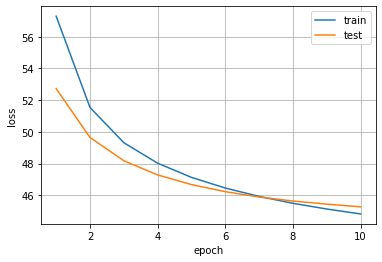

In [26]:
NUM_EPOCHS = 10

train(model, train_loader, val_loader, criterion, optimizer, clip, device, NUM_EPOCHS)

## Генерация

In [27]:
def generate(model, question, bos_index=2, eos_index=3, max_sequence=64):
    
    # токенизируем текст вопроса
    tokenized = tokenizer.encode([question])
    x = torch.tensor(tokenized).long().to(device)
    
    model.eval()

    with torch.no_grad():

        # получим представления энкодера от нашего вопроса
        emb_q = model.embedding_layer(x)
        lstm_enc_out, mem = model.lstm_enc(emb_q)
        values = model.values(lstm_enc_out)
         
        keys = model.keys(lstm_enc_out)

        # на вход генератору подаем BOS
        current_tokens = torch.IntTensor([bos_index]).unsqueeze(0).to(device)
        emb = model.embedding_layer(current_tokens)

        # начинаем генерацию
        for timestamp in range(max_sequence):

            lstm_dec_out, mem = model.lstm_dec(emb, mem)

            # считаем queries
            queries = model.queries(lstm_dec_out)
             
            # перемножаем keys и queries
            energy = torch.einsum("nqd, nkd->nqk", [queries, keys])
             
            # пропускаем через softmax
            attention = torch.softmax(energy / (model.emb_dim ** (1/2)), dim=2)
             
            # взвешиваем values
            att_out = torch.einsum('nql, nld->nqd', [attention, values])
             
            # усредняем вектор декодера с выходом attention и переводим в предсказание
            next = model.language_model_head((lstm_dec_out+att_out)/2)

            current_tokens = torch.cat((current_tokens, next.argmax(dim=-1)[:,-1].unsqueeze(0)), dim=-1)
            emb = model.embedding_layer(current_tokens)

            # останавливаем генерацию, когда встретили токен конца предложения
            if current_tokens[:,-1] == eos_index:
                break


    tokens = current_tokens[:,1:].detach().cpu().numpy()
    predicted_text = tokenizer.decode(tokens.tolist())[0]
    
    return predicted_text[:predicted_text.index('<EOS>')]

In [30]:
# общение с моделью
while True:
    question = input('Ваш вопрос: ')
    if question in ['стоп', 'хватит']:
        break
    print('Ответ: ', generate(model, question))

Ваш вопрос: сколько стоит мотор
Ответ:  около 200р. цена дороже.
Ваш вопрос: какой самый глупый вопрос задаёт мужчина женщине?
Ответ:  он не задаёт
Ваш вопрос: как найти друзей на улице?
Ответ:  никак. друзей искать не найдешь
Ваш вопрос: стоп
